<a href="https://colab.research.google.com/github/yukiharada1228/neural_network/blob/main/Detic%E3%81%A7%E3%83%9A%E3%83%83%E3%83%88%E3%83%9C%E3%83%88%E3%83%AB%E3%82%92%E6%A4%9C%E5%87%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ランタイムのタイプをGPUに変更してください

# detectron2をインストールします
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.6'

# このタイミングでセッションを再起動してください

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.6) to /tmp/pip-req-build-x59glga_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-x59glga_
  Running command git checkout -q d1e04565d3bec8719335b88be9e9b961bf3ec464
  Resolved https://github.com/facebookresearch/detectron2.git to commit d1e04565d3bec8719335b88be9e9b961bf3ec464
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 892.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: fi

In [ ]:
# Deticをgithubからクローンしインストールします
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules

# Deticの依存ライブラリをインストールします
!cd Detic && pip install -r requirements.txt

Cloning into 'Detic'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 210 (delta 59), reused 56 (delta 56), pack-reused 99
Receiving objects: 100% (210/210), 3.58 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Submodule 'third_party/CenterNet2' (https://github.com/xingyizhou/CenterNet2.git) registered for path 'third_party/CenterNet2'
Submodule 'third_party/Deformable-DETR' (https://github.com/fundamentalvision/Deformable-DETR.git) registered for path 'third_party/Deformable-DETR'
Cloning into '/content/Detic/third_party/CenterNet2'...
remote: Enumerating objects: 13925, done.        
remote: Counting objects: 100% (949/949), done.        
remote: Compressing objects: 100% (101/101), done.        
remote: Total 13925 (delta 887), reused 854 (delta 846), pack-reused 12976        
Receiving objects: 100% (13925/13925), 5.08 MiB | 15.30 MiB/s, done.
Resolving deltas: 10

In [ ]:
# Detectron2のロガーをセットアップ
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 一般的なライブラリをインポート
import torch
import sys
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# Detectron2の一般的なユーティリティをインポート
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Deticライブラリ
%cd Detic
sys.path.insert(0, 'third_party/CenterNet2/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

/content/Detic


In [ ]:
# 検出器を構築し、事前学習済みの重みをダウンロードする
cfg = get_cfg()
add_centernet_config(cfg)  # CenterNetの設定を追加
add_detic_config(cfg)  # Deticの設定を追加
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")  # 構成ファイルをマージ
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'  # 事前学習済みの重みを指定
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # このモデルの閾値を設定
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'  # 重みのパスを指定
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True  # より良い視覚化のために1つのクラスの提案のみを設定。すべてのクラスを使用する場合はFalseに設定。
# cfg.MODEL.DEVICE='cpu'  # CPUのみモードを使用する場合は、このコメントを外してください。
predictor = DefaultPredictor(cfg)  # デフォルトの予測器を作成

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth: 702MB [00:08, 84.9MB/s]                          


--2024-05-27 21:05:38--  https://otonanswer.jp/wp-content/uploads/2023/04/202304drink01.jpg
Resolving otonanswer.jp (otonanswer.jp)... 172.67.75.19, 104.26.6.161, 104.26.7.161, ...
Connecting to otonanswer.jp (otonanswer.jp)|172.67.75.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119222 (116K) [image/jpeg]
Saving to: ‘juice.jpg’

juice.jpg           100%[===================>] 116.43K  --.-KB/s    in 0.02s   

2024-05-27 21:05:38 (5.49 MB/s) - ‘juice.jpg’ saved [119222/119222]



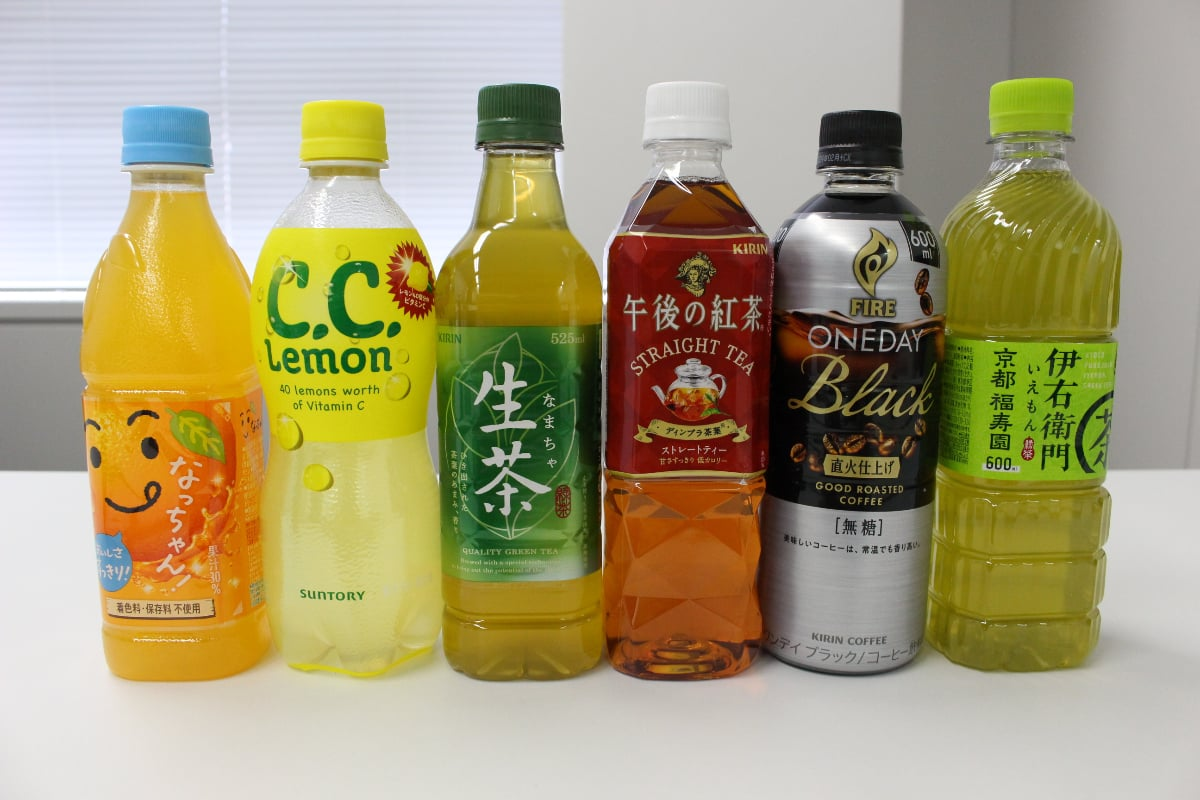

In [ ]:
# サンプル画像をダウンロードして表示します。
!wget -O juice.jpg https://otonanswer.jp/wp-content/uploads/2023/04/202304drink01.jpg
im = cv2.imread("./juice.jpg")  # 画像を読み込みます
cv2_imshow(im)  # 画像を表示します

In [ ]:
# モデルのボキャブラリーをカスタマイズして、事前学習済みのCLIPモデルを使用して単語埋め込みを取得します。

from detic.modeling.text.text_encoder import build_text_encoder

def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)  # CLIPのテキストエンコーダーを構築
    text_encoder.eval()  # モデルを評価モードに設定
    texts = [prompt + x for x in vocabulary]  # テキストを準備
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()  # 埋め込みを取得
    return emb

# カスタムボキャブラリーを定義
vocabulary = [
    'bottled orange',
    'bottled lemon',
    'bottled tea',
    'bottled coffiee'
]

metadata = MetadataCatalog.get("__unused")  # メタデータを取得
metadata.thing_classes = vocabulary  # モデルのボキャブラリーを変更

# CLIPモデルを使用してカスタムボキャブラリーの単語埋め込みを取得
classifier = get_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)

# 分類器とクラスのリセット
reset_cls_test(predictor.model, classifier, num_classes)

# 視覚化の閾値をリセット
output_score_threshold = 0.6
for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 212MiB/s]


Loading pretrained CLIP


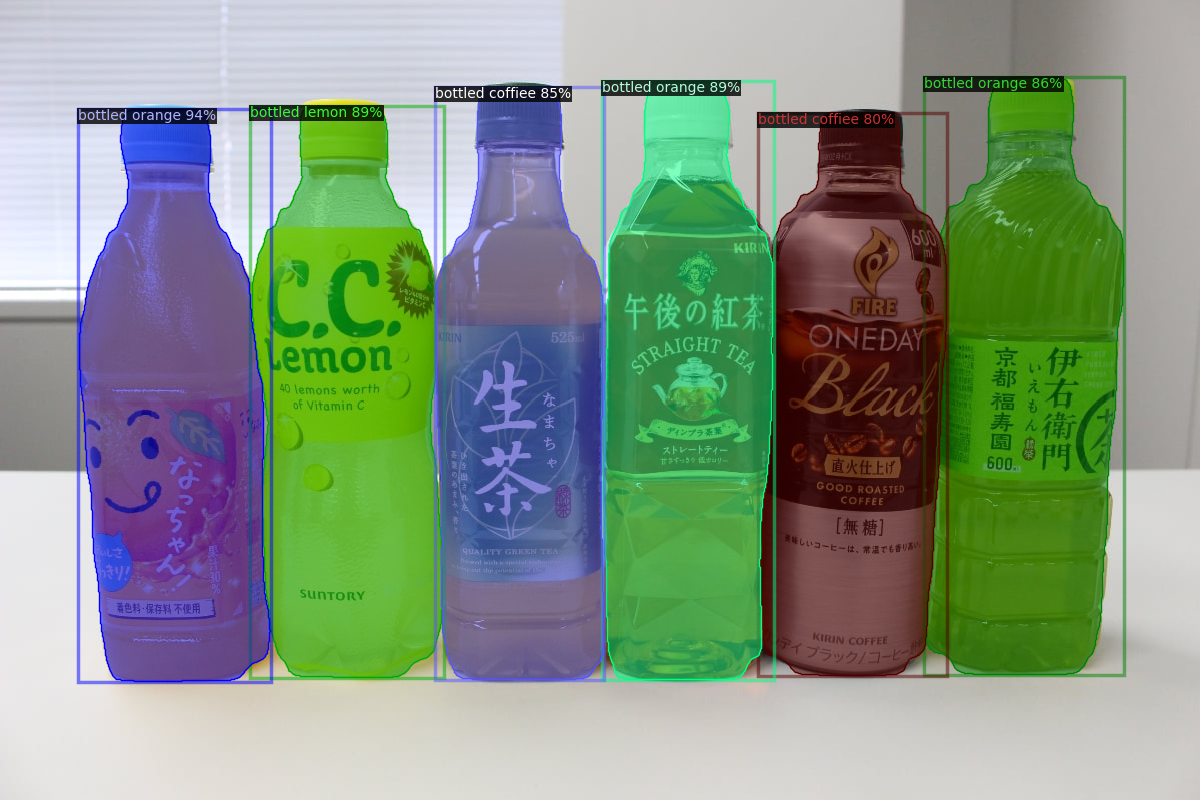

In [ ]:
# モデルを実行して結果を表示します
outputs = predictor(im)  # 画像をモデルに渡して予測を取得
v = Visualizer(im[:, :, ::-1], metadata)  # 可視化器を作成
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))  # 予測結果を画像に描画
cv2_imshow(out.get_image()[:, :, ::-1])  # 画像を表示

In [ ]:
# モデルの出力フォーマットの仕様については、https://detectron2.readthedocs.io/tutorials/models.html#model-output-format を参照
print(outputs["instances"].pred_classes) # クラスインデックス
print([metadata.thing_classes[x] for x in outputs["instances"].pred_classes.cpu().tolist()]) # クラス名
print(outputs["instances"].scores) # 信頼度スコア
print(outputs["instances"].pred_boxes) # 境界ボックス

tensor([0, 0, 1, 0, 3, 3], device='cuda:0')
['bottled orange', 'bottled orange', 'bottled lemon', 'bottled orange', 'bottled coffiee', 'bottled coffiee']
tensor([0.9373, 0.8947, 0.8887, 0.8639, 0.8538, 0.7957], device='cuda:0')
Boxes(tensor([[  78.3254,  109.0124,  270.9164,  682.2299],
        [ 601.6377,   81.2027,  774.1597,  680.4078],
        [ 250.4572,  106.1285,  443.9457,  678.1036],
        [ 924.3038,   77.2778, 1123.9559,  675.1109],
        [ 435.2359,   86.5564,  603.7692,  680.1379],
        [ 757.6812,  112.6659,  947.2933,  676.1085]], device='cuda:0'))
